# Entrenamiento del meta-modelo

Aqué entrenaremos un modelo XGBoosting 

Como tenemos los datos un poco desordenados, primero los tengo que organizar, ya que para el entrenamiento necesito los datos con los que se entreno el PPO, los labeles obtenidos en el notebook `00_meta_labeling`, y un indicador adicional de regímenes que lo sacamos mediante cadenas de markov en el notebook `01_hmm`.

Voy a cargar los datos in-sample y out-of-sample, y los datos de los labels.

In [1]:
import sys
import os
import pandas as pd

# Añadir el directorio raíz del proyecto al PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# SPY VOLUMEN

##### Cargar datos
Primero hay que recopilar toda la información que esta desperdigada por ahí

In [2]:
## Indicadores
SPY_VOLUME_IN_SAMPLE = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\02_training_data\SPY_volume_processed_in_sample.parquet')
SPY_VOLUME_OO_SAMPLE = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\02_training_data\SPY_volume_processed_out_of_sample.parquet')

## Predicciones PPO
spy_volume_ppo_in_sample_preds = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\04_validation\SPY_volume_ppo_signals.parquet')
spy_volume_ppo_out_of_sample_preds = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\04_validation\SPY_volume_returns.parquet')

## HMM
spy_volume_hmm_all = pd.read_parquet('spy_volume_hmm.parquet')

### ground truth labels (three barrier)
ground_truth_all = pd.read_parquet('spy_with_labels.parquet')

In [3]:
SPY_VOLUME_IN_SAMPLE.set_index('date', inplace=True)
SPY_VOLUME_IN_SAMPLE.drop(['close','feature_open','feature_high',	'feature_low',	'feature_close'], axis = 1, inplace=True)
SPY_VOLUME_OO_SAMPLE.set_index('date', inplace=True)
SPY_VOLUME_OO_SAMPLE.drop(['close','feature_open','feature_high',	'feature_low',	'feature_close'], axis = 1, inplace=True)

spy_volume_ppo_in_sample_preds.set_index('date', inplace=True)
spy_volume_ppo_out_of_sample_preds.set_index('date', inplace=True)
spy_volume_ppo_out_of_sample_preds = spy_volume_ppo_out_of_sample_preds['predicted_actions'].copy()

spy_volume_hmm_all.set_index('date', inplace=True)

ground_truth_all = ground_truth_all['label'].copy()

##### Limpieza
Ahora hay que construir los conjuntos nuevos:
* Conjunto de entrenamiento in-sample y validación out-of sample: Indicadores inciales + predicciones PPO + HMM. Target variable: Meta-labels.

In [4]:
spy_vol_in_sample_merged = pd.merge(SPY_VOLUME_IN_SAMPLE, spy_volume_ppo_in_sample_preds, left_index=True, right_index=True, how='inner')
spy_vol_in_sample_merged = pd.merge(spy_vol_in_sample_merged, spy_volume_hmm_all, left_index=True, right_index=True, how='inner')
spy_vol_in_sample_merged = pd.merge(spy_vol_in_sample_merged, ground_truth_all, left_index=True, right_index=True, how='inner')

spy_vol_in_sample_merged['meta_labels'] = (spy_vol_in_sample_merged['label'] == spy_vol_in_sample_merged['predicted_actions']).astype(int)

In [5]:
spy_vol_oo_sample_merged = pd.merge(SPY_VOLUME_OO_SAMPLE, spy_volume_ppo_out_of_sample_preds, left_index=True, right_index=True, how='inner')
spy_vol_oo_sample_merged = pd.merge(spy_vol_oo_sample_merged, spy_volume_hmm_all, left_index=True, right_index=True, how='inner')
spy_vol_oo_sample_merged = pd.merge(spy_vol_oo_sample_merged, ground_truth_all, left_index=True, right_index=True, how='inner')

spy_vol_oo_sample_merged['meta_labels'] = (spy_vol_oo_sample_merged['label'] == spy_vol_oo_sample_merged['predicted_actions']).astype(int)

In [6]:
print(f'Train samples: {len(spy_vol_in_sample_merged)} | Validation samples: {len(spy_vol_oo_sample_merged)}')

Train samples: 50001 | Validation samples: 3416


## Entrenamiento del meta-modelo

In [7]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [8]:
X = spy_vol_in_sample_merged.drop(columns=['meta_labels', 'label'], axis = 1)  # Elimina la columna meta_label para obtener solo las características
y = spy_vol_in_sample_merged['meta_labels'] 

##### Entrenamiento del primer modelo
80/20 sobre los datos de entrenamiento, solo para medirlo

In [9]:
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Crear el modelo XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Entrenar el modelo
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy sobre el 20% del conjunto de entrenamiento: {accuracy:.2f}")

Accuracy sobre el 20% del conjunto de entrenamiento: 0.71


##### Entrenamiento del meta modelo
Entrenamiento del modelo con todos los datos de entrenamiento

In [11]:
# Crear el modelo XGBoost
model2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Entrenar el modelo
model2.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

##### Predicción sobre el conjunto de validación out-of-sample

In [12]:
X_out_of_sample = spy_vol_oo_sample_merged.drop(columns=['meta_labels', 'label'])  # Elimina la columna meta_label si existe

spy_vol_oo_sample_merged['meta_labels_pred'] = model2.predict(X_out_of_sample)

accuracy = accuracy_score(spy_vol_oo_sample_merged['meta_labels'], spy_vol_oo_sample_merged['meta_labels_pred'])

print(f"Accuracy en el conjunto de entrenamiento: {accuracy:.2f}")

Accuracy en el conjunto de entrenamiento: 0.69


### Predicciones filtradas por el meta-modelo
Ahora, se usan las predicciones del meta-modelo para filtrar las predicciones del modelo primario.

La idea es que solo confiar en las acciones predichas por el modelo primario si el meta-modelo sugiere que se debe confiar en ellas (es decir, cuando meta_labels_pred es 1). Si el meta-modelo predice 0, se puede optar por:

* No tomar ninguna acción (por ejemplo, cambiar la acción a 0 para "hold").
* Tomar una acción específica como vender (cambiar a -1) o no hacer nada.

Yo le voy a decir que si el meta-modelo no lo aprueba, se quede en hold.

In [13]:
spy_vol_oo_sample_merged['filtered_actions'] = spy_vol_oo_sample_merged.apply(
    lambda row: row['predicted_actions'] if row['meta_labels_pred'] == 1 else 0, axis=1
)

In [14]:
spy_vol_oo_sample_merged['filtered_actions'].value_counts()

filtered_actions
 0.0    2505
-1.0     577
 1.0     334
Name: count, dtype: int64

In [15]:
spy_vol_oo_sample_merged['predicted_actions'].value_counts()

predicted_actions
-1    1426
 0    1346
 1     644
Name: count, dtype: int64

In [16]:
spy_vol_oo_sample_merged['label'].value_counts()

label
 1.0    1847
-1.0    1540
 0.0      29
Name: count, dtype: int64

### Matrices de confusión
Para ver si el meta-labeling ha mejorado el recall, saco dos matrices de confusion: una del modelo primario vs ground truth, y otra de las acciones filtradas vs ground truth.

In [17]:
from sklearn.metrics import classification_report

In [18]:
predicciones_sin_filtrar = (spy_vol_oo_sample_merged['predicted_actions']==spy_vol_oo_sample_merged['label']).astype(int)
predicciones_filtradas = (spy_vol_oo_sample_merged['filtered_actions']==spy_vol_oo_sample_merged['label']).astype(int)

binary_ground_truth = spy_vol_oo_sample_merged['label'].apply(lambda x: 1 if x in [-1, 1] else 0)

In [19]:
report = classification_report(binary_ground_truth, predicciones_sin_filtrar, target_names=['No Trade', 'Trade'])
print(report)


              precision    recall  f1-score   support

    No Trade       0.01      0.76      0.02        29
       Trade       0.99      0.29      0.45      3387

    accuracy                           0.30      3416
   macro avg       0.50      0.53      0.24      3416
weighted avg       0.98      0.30      0.45      3416



In [20]:
report = classification_report(binary_ground_truth, predicciones_filtradas, target_names=['No Trade', 'Trade'])
print(report)

              precision    recall  f1-score   support

    No Trade       0.00      0.24      0.00        29
       Trade       0.95      0.13      0.23      3387

    accuracy                           0.13      3416
   macro avg       0.48      0.19      0.12      3416
weighted avg       0.95      0.13      0.23      3416



In [21]:
predicciones_filtradas.value_counts()

0    2941
1     475
Name: count, dtype: int64

In [22]:
binary_ground_truth.value_counts()

label
1    3387
0      29
Name: count, dtype: int64

In [23]:
report = classification_report(spy_vol_oo_sample_merged['label'], spy_vol_oo_sample_merged['predicted_actions'])
print(report)

              precision    recall  f1-score   support

        -1.0       0.46      0.42      0.44      1540
         0.0       0.01      0.24      0.01        29
         1.0       0.53      0.19      0.28      1847

    accuracy                           0.29      3416
   macro avg       0.33      0.28      0.24      3416
weighted avg       0.50      0.29      0.35      3416



In [24]:
report = classification_report(spy_vol_oo_sample_merged['label'], spy_vol_oo_sample_merged['filtered_actions'])
print(report)

              precision    recall  f1-score   support

        -1.0       0.49      0.18      0.26      1540
         0.0       0.01      0.76      0.02        29
         1.0       0.52      0.09      0.16      1847

    accuracy                           0.14      3416
   macro avg       0.34      0.34      0.15      3416
weighted avg       0.50      0.14      0.21      3416



In [25]:
spy_vol_oo_sample_merged['filtered_actions']

date
2024-01-01 10:09:00    0.0
2024-01-01 10:13:00    0.0
2024-01-01 10:17:00   -1.0
2024-01-01 10:21:00   -1.0
2024-01-01 10:25:00    0.0
                      ... 
2024-06-25 15:47:00    0.0
2024-06-25 15:53:00    0.0
2024-06-25 15:58:00    0.0
2024-06-25 15:59:00    0.0
2024-06-25 16:00:00    0.0
Name: filtered_actions, Length: 3416, dtype: float64

### Calculo de los retornos con las acciones filtradas


In [26]:
SPY_VOLUME_OO_SAMPLE = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\02_training_data\SPY_volume_processed_out_of_sample.parquet')
SPY_VOLUME_OO_SAMPLE.set_index('date', inplace=True)
spy_volume_ppo_out_of_sample_preds = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\04_validation\SPY_volume_returns.parquet')
spy_volume_ppo_out_of_sample_preds.set_index('date', inplace=True)
final_data = pd.merge(SPY_VOLUME_OO_SAMPLE, spy_vol_oo_sample_merged['filtered_actions'], left_index=True, right_index=True, how='inner')
final_data = pd.merge(final_data, spy_volume_ppo_out_of_sample_preds['predicted_actions'], left_index=True, right_index=True, how='inner')
final_data

,feature_open,feature_high,feature_low,feature_close,feature_SMA_20,feature_SMA_50,feature_EMA_14,feature_BBL_20_2.0,feature_BBM_20_2.0,feature_BBU_20_2.0,...,feature_BBP_20_2.0,feature_RSI,feature_MACD,feature_MACD_Signal,feature_MACD_Diff,feature_ATR,feature_CCI,close,filtered_actions,predicted_actions
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 10:09:00,0.782213,0.785165,0.783098,0.781709,0.788199,0.787212,0.786822,0.791473,0.788199,0.779994,...,0.497107,0.490329,0.587509,0.601845,0.669530,0.113524,0.541315,475.150,0.0,0
2024-01-01 10:13:00,0.782213,0.785165,0.783098,0.781709,0.788175,0.787264,0.786817,0.791473,0.788175,0.779945,...,0.502969,0.490329,0.587548,0.601713,0.669823,0.118100,0.539850,475.150,0.0,1
2024-01-01 10:17:00,0.782213,0.785165,0.783098,0.781709,0.788114,0.787335,0.786812,0.791600,0.788114,0.779697,...,0.522630,0.490329,0.587597,0.601618,0.670073,0.122350,0.537206,475.150,-1.0,-1
2024-01-01 10:21:00,0.782213,0.785165,0.783098,0.781709,0.788086,0.787409,0.786808,0.791630,0.788086,0.779612,...,0.534094,0.490329,0.587653,0.601556,0.670285,0.126297,0.535428,475.150,-1.0,-1
2024-01-01 10:25:00,0.782213,0.785165,0.783098,0.781709,0.788145,0.787462,0.786805,0.791901,0.788145,0.779456,...,0.520659,0.490329,0.587715,0.601520,0.670462,0.129961,0.533333,475.150,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-25 15:47:00,0.983690,0.984979,0.985237,0.983052,0.990148,0.993229,0.989423,0.987962,0.990148,0.984004,...,0.630586,0.525978,0.585783,0.577782,0.706279,0.090814,0.584495,544.410,0.0,0
2024-06-25 15:53:00,0.983050,0.983552,0.984655,0.983415,0.990277,0.993183,0.989622,0.987929,0.990277,0.984293,...,0.638792,0.535526,0.590215,0.583073,0.705912,0.086835,0.566136,544.535,0.0,1
2024-06-25 15:58:00,0.983341,0.984600,0.985295,0.984709,0.990370,0.993169,0.989969,0.987776,0.990370,0.984632,...,0.694949,0.568822,0.597521,0.588977,0.709994,0.084470,0.589388,544.980,0.0,-1


In [27]:
final_data.reset_index(inplace=True)

In [28]:
def calculate_returns(data:pd.DataFrame, action_name: str):
    # Inicializar variables para trackear la posición y el cash
    position = 0
    cash = 0

    # Lista para almacenar los retornos de la estrategia
    returns = []
    

    for i in range(1, len(data)):
        
        action = data.loc[i,action_name]
        #real_action = fixed_validation_data.loc[i, 'real_actions_taken']
        price = data.loc[i, 'close']
        prev_price = data.loc[i-1, 'close']
        
        # Comprar
        if action == 1:  
            # Actualizar posición (por simplicidad, se asume compra completa)
            position += 1
            cash -= price

            # No hay retorno inmediato al comprar
            returns.append(0)  
            
        
        # Vender
        elif action == -1:  
            # Vender solo si tienes activo
            if position > 0:  
                returns.append((price - prev_price) / prev_price)  # Retorno de la venta
                cash += price
                position -= 1
            else:
                returns.append(0)  # Si no puedes vender, el retorno es 0
                
        
        # Mantener
        else: 
            if position > 0:  # Si tienes posición, registrar retorno
                returns.append((price - prev_price) / prev_price)
                
            else:
                returns.append(0)  # Si no tienes posición, el retorno es 0
        

    # el primer retorno es nan, asique lo sustituyo por 0.
    returns.insert(0, 0)

    return pd.Series([float(num) for num in returns])

In [29]:
filtered_returns = calculate_returns(final_data,'filtered_actions')
predicted_returns = calculate_returns(final_data,'predicted_actions')

buy_and_hold = final_data['close'].pct_change()

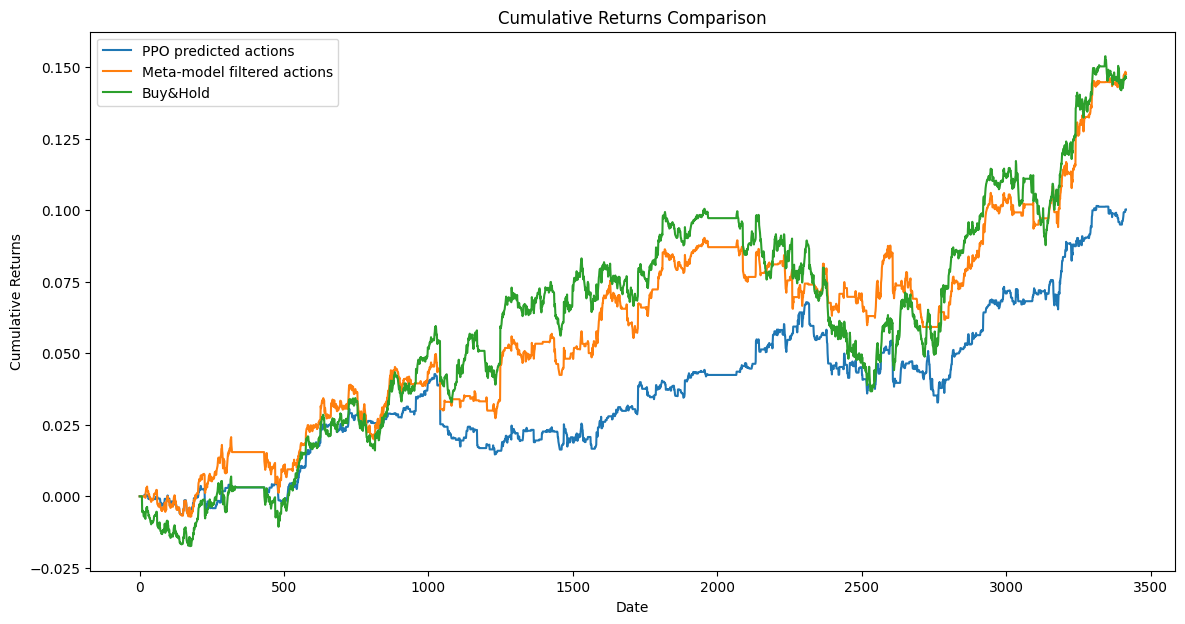

In [30]:
# Crear figura
plt.figure(figsize=(14, 7))

# Calcular el "cumulative returns" de las estrategias y del benchmark
cumulative_filtered_returns = (1 + filtered_returns).cumprod() - 1
cumulative_predicted_returns = (1 + predicted_returns).cumprod() - 1
cumulative_buy_and_hold = (1 + buy_and_hold).cumprod() - 1


# Graficar
plt.plot(cumulative_predicted_returns, label='PPO predicted actions')
plt.plot(cumulative_filtered_returns, label='Meta-model filtered actions')
plt.plot(cumulative_buy_and_hold, label='Buy&Hold')



# Agregar etiquetas y título
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

# Mostrar el gráfico
plt.show()

In [32]:
df = pd.DataFrame({
    'date':final_data['date'],
    'filtered_returns': filtered_returns,
    'predicted_returns': predicted_returns,
    'buy_and_hold': buy_and_hold
})

#df.set_index('date', inplace = True)
df.fillna(0, inplace=True)

# Save the DataFrame to a CSV file
df.to_parquet('meta_model_spy_volume_results.parquet', index=False)